## Stack Overflow Survey Analysis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from scipy import stats

# pipelines
from sklearn.pipeline import Pipeline

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# NLP transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# classifiers you can use
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score

In [2]:
df_20 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2020/survey_results_public.csv')
# df_19 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2019/survey_results_public.csv')
# df_18 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2018/survey_results_public.csv')
def prettify(ax):
  ax.grid(False)
  ax.set_frame_on(False)
  ax.tick_params(top=False, bottom=False, left=False, right=False, labelbottom=False)

In [3]:
#choosing relevant features from 2020 survey
relevant_data_20 = df_20[['Respondent', 'Country', 'Age1stCode', 'UndergradMajor','Hobbyist', 'Employment','DevType', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'PlatformDesireNextYear', 'PlatformWorkedWith']]

In [4]:
relevant_data_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              64461 non-null  int64 
 1   Country                 64072 non-null  object
 2   Age1stCode              57900 non-null  object
 3   UndergradMajor          50995 non-null  object
 4   Hobbyist                64416 non-null  object
 5   Employment              63854 non-null  object
 6   DevType                 49370 non-null  object
 7   DatabaseDesireNextYear  44070 non-null  object
 8   DatabaseWorkedWith      49537 non-null  object
 9   PlatformDesireNextYear  50605 non-null  object
 10  PlatformWorkedWith      53843 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.4+ MB


In [5]:
relevant_data_20.head(5)

,Respondent,Country,Age1stCode,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
0,1,Germany,13,"Computer science, computer engineering, or sof...",Yes,"Independent contractor, freelancer, or self-em...","Developer, desktop or enterprise applications;...",Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows
1,2,United Kingdom,19,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack;Developer, mobile",NaN,NaN,iOS;Kubernetes;Linux;MacOS,iOS
2,3,Russian Federation,15,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,18,"Computer science, computer engineering, or sof...",Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,5,United States,16,"Computer science, computer engineering, or sof...",Yes,Employed full-time,NaN,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows


In [6]:
#counting number of developers per country
country_20 = relevant_data_20['Country'].value_counts()
top_country_20 = country_20.head(30).sort_values(ascending = True)

<AxesSubplot:title={'center':'Number of Developers from Countries'}>

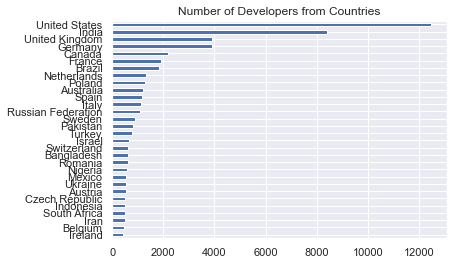

In [7]:
top_country_20.plot(kind = 'barh', title = 'Number of Developers from Countries')

In [8]:
'''taking out NaN's in DevType column while preserving the rest of the 
columns that may also have NaN's in order to get an accurate count of developers per type.'''

dev_types = ['Developer, back-end', 
             'Developer, full-stack', 
             'Developer, front-end', 
             'Developer, desktop or enterprise applications', 
             'Developer, mobile', 
             'DevOps specialist',
             'Database administrator',
             'Designer',
             'System administrator',
             'Developer, embedded applications or devices',
             'Data or business analyst',
             'Data scientist or machine learning specialist',
             'Developer, QA or test',
             'Engineer, data'
            ]

all_devs_df = relevant_data_20.loc[relevant_data_20['DevType'].isin(dev_types)]

In [9]:
all_devs_df.head(50)

,Respondent,Country,Age1stCode,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
8,9,Tunisia,20,"Computer science, computer engineering, or sof...",No,"Independent contractor, freelancer, or self-em...","Developer, full-stack",NaN,NaN,NaN,WordPress
16,17,United States,14,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, full-stack",Cassandra;Elasticsearch;MariaDB;PostgreSQL;Redis,Microsoft SQL Server;PostgreSQL,Docker;Kubernetes;Microsoft Azure,NaN
17,18,United States,12,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, back-end",Elasticsearch;PostgreSQL;Redis;SQLite,Elasticsearch;MariaDB;MySQL;Redis;SQLite,Linux,AWS;Linux
18,19,United States,15,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack",MariaDB;MongoDB,MariaDB;Microsoft SQL Server,iOS;Slack Apps and Integrations,Windows
19,20,Spain,18,"Another engineering discipline (such as civil,...",Yes,Employed full-time,"Developer, desktop or enterprise applications",NaN,IBM DB2;MariaDB;Microsoft SQL Server;MySQL,NaN,Heroku;Linux;Windows
23,24,Germany,14,"Another engineering discipline (such as civil,...",Yes,Employed full-time,"Developer, back-end",Cassandra;PostgreSQL,PostgreSQL;SQLite,AWS;Docker;Kubernetes;Linux;MacOS,Docker;Kubernetes;Linux;MacOS
25,26,Canada,12,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack",NaN,PostgreSQL,NaN,Linux;MacOS;Slack Apps and Integrations
36,37,France,16,Web development or web design,Yes,Employed full-time,"Developer, front-end",Elasticsearch,MariaDB;MongoDB;MySQL;PostgreSQL,Docker;Google Cloud Platform;Raspberry Pi,Arduino;Heroku;iOS;Linux;MacOS;Microsoft Azure...
44,45,France,13,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, full-stack",Elasticsearch;MongoDB,Elasticsearch;MongoDB;MySQL,Linux,Heroku;Linux;Windows
47,48,United States,30,Fine arts or performing arts (such as graphic ...,No,Employed full-time,"Developer, back-end",PostgreSQL;Redis,PostgreSQL;Redis,AWS;Google Cloud Platform,AWS;Google Cloud Platform


In [10]:
df = pd.concat([all_devs_df, all_devs_df['DatabaseWorkedWith'].str.split(';', expand=True)], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  0                       9981 non-null   object
 12  1                       6655 non-null   object
 13  2                       3836 non-null   object
 14  3                       2008 non-null   object
 15  4 

In [12]:
df = df.rename(columns = {0: "CurrentDB0",
                     1: "CurrentDB1",
                     2: "CurrentDB2",
                     3: "CurrentDB3",
                     4: "CurrentDB4", 
                     5:"CurrentDB5",
                     6:"CurrentDB6",
                     7:"CurrentDB7",
                     8:"CurrentDB8",
                     9:"CurrentDB9",
                     10:"CurrentDB10",
                     11:"CurrentDB11",
                     12:"CurrentDB12",
                     13:"CurrentDB13",})

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  CurrentDB0              9981 non-null   object
 12  CurrentDB1              6655 non-null   object
 13  CurrentDB2              3836 non-null   object
 14  CurrentDB3              2008 non-null   object
 15  Cu

In [14]:
df = pd.concat([df, df['DatabaseDesireNextYear'].str.split(';', expand=True)], axis=1)

In [15]:
df = df.rename(columns = {0: "DesiredDB0",
                     1: "DesiredDB1",
                     2: "DesiredDB2",
                     3: "DesiredDB3",
                     4: "DesiredDB4", 
                     5:"DesiredDB5",
                     6:"DesiredB6",
                     7:"DesiredDB7",
                     8:"DesiredDB8",
                     9:"DesiredDB9",
                     10:"DesiredDB10",
                     11:"DesiredDB11",
                     12:"DesiredDB12",
                     13:"DesiredDB13",})

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  CurrentDB0              9981 non-null   object
 12  CurrentDB1              6655 non-null   object
 13  CurrentDB2              3836 non-null   object
 14  CurrentDB3              2008 non-null   object
 15  Cu

In [17]:
df = pd.concat([df, df['PlatformDesireNextYear'].str.split(';', expand=True)], axis=1)

In [18]:
df = df.rename(columns = {0: "DesiredPlatform0",
                     1: "DesiredPlatform1",
                     2: "DesiredPlatform2",
                     3: "DesiredPlatform3",
                     4: "DesiredPlatform4", 
                     5:"DesiredPlatform5",
                     6:"DesiredPlatform6",
                     7:"DesiredPlatform7",
                     8:"DesiredPlatform8",
                     9:"DesiredPlatform9",
                     10:"DesiredPlatform10",
                     11:"DesiredPlatform11",
                     12:"DesiredPlatform12",
                     13:"DesiredPlatform13",
                    14:"DesiredPlatform14",
                     15:"DesiredPlatform15",                                 
                                                           })

In [19]:
df = pd.concat([df, df['PlatformWorkedWith'].str.split(';', expand=True)], axis=1)

In [20]:
df = df.rename(columns = {0: "CurrentPlatform0",
                     1: "CurrentPlatform1",
                     2: "CurrentPlatform2",
                     3: "CurrentPlatform3",
                     4: "CurrentPlatform4", 
                     5:"CurrentPlatform5",
                     6:"CurrentPlatform6",
                     7:"CurrentPlatform7",
                     8:"CurrentPlatform8",
                     9:"CurrentPlatform9",
                     10:"CurrentPlatform10",
                     11:"CurrentPlatform11",
                     12:"CurrentPlatform12",
                     13:"CurrentPlatform13",
                    14:"CurrentPlatform14",
                     15:"CurrentPlatform15",                                 
                                                           })

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  CurrentDB0              9981 non-null   object
 12  CurrentDB1              6655 non-null   object
 13  CurrentDB2              3836 non-null   object
 14  CurrentDB3              2008 non-null   object
 15  Cu

In [22]:
df_toy = df[['Country','DevType','CurrentDB0', 'DesiredDB0', 'DesiredPlatform0', 'CurrentPlatform0']]

In [23]:
df_toy.head()

,Country,DevType,CurrentDB0,DesiredDB0,DesiredPlatform0,CurrentPlatform0
8,Tunisia,"Developer, full-stack",NaN,NaN,NaN,WordPress
16,United States,"Developer, full-stack",Microsoft SQL Server,Cassandra,Docker,NaN
17,United States,"Developer, back-end",Elasticsearch,Elasticsearch,Linux,AWS
18,United States,"Developer, full-stack",MariaDB,MariaDB,iOS,Windows
19,Spain,"Developer, desktop or enterprise applications",IBM DB2,NaN,NaN,Heroku


In [24]:
df_toy = df_toy.dropna()
print(len(df_toy))
print(df_toy)

7451
              Country                   DevType            CurrentDB0  \
17      United States       Developer, back-end         Elasticsearch   
18      United States     Developer, full-stack               MariaDB   
23            Germany       Developer, back-end            PostgreSQL   
36             France      Developer, front-end               MariaDB   
44             France     Developer, full-stack         Elasticsearch   
...               ...                       ...                   ...   
64416      Bangladesh  Data or business analyst  Microsoft SQL Server   
64420        Mongolia     Developer, full-stack                Oracle   
64422  United Kingdom       Developer, back-end                 MySQL   
64428   United States      System administrator               MariaDB   
64429           Spain         Developer, mobile              Firebase   

                 DesiredDB0 DesiredPlatform0 CurrentPlatform0  
17            Elasticsearch            Linux          

In [25]:
def count_db(df_toy, column_string,db_name):
    '''Count the number of current or desired databases'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == db_name:
            counter += 1
    return counter
    

In [26]:
Cur_MySQL = count_db(df_toy, "CurrentDB0","MySQL")
Cur_PostgreSQL = count_db(df_toy, "CurrentDB0","PostgreSQL")
Cur_Microsoft_SQL_Server = count_db(df_toy, "CurrentDB0","Microsoft SQL Server")
Cur_SQLite = count_db(df_toy, "CurrentDB0","SQLite")
Cur_MongoDB = count_db(df_toy, "CurrentDB0","MongoDB")
Cur_Redis = count_db(df_toy, "CurrentDB0","Redis")
Cur_MariaDB = count_db(df_toy, "CurrentDB0","MariaDB")
Cur_Oracle = count_db(df_toy, "CurrentDB0","Oracle")
Cur_Firebase = count_db(df_toy, "CurrentDB0","Firebase")
Cur_Elasticsearch = count_db(df_toy, "CurrentDB0","Elasticsearch")
Cur_DynamoDB = count_db(df_toy, "CurrentDB0","DynamoDB")
Cur_Cassandra = count_db(df_toy, "CurrentDB0","Cassandra")
Cur_IBM_DB2 = count_db(df_toy, "CurrentDB0","IBM DB2")
Cur_Couchbase= count_db(df_toy, "CurrentDB0","Couchbase")

Current_DBs = [
Cur_MySQL,
Cur_PostgreSQL,
Cur_Microsoft_SQL_Server,
Cur_SQLite,
Cur_MongoDB,
Cur_Redis,
Cur_MariaDB,
Cur_Oracle,
Cur_Firebase,
Cur_Elasticsearch,
Cur_DynamoDB,
Cur_Cassandra,
Cur_IBM_DB2,
Cur_Couchbase
]

sum = 0
for i in Current_DBs:
    sum += i
print(sum)

7451


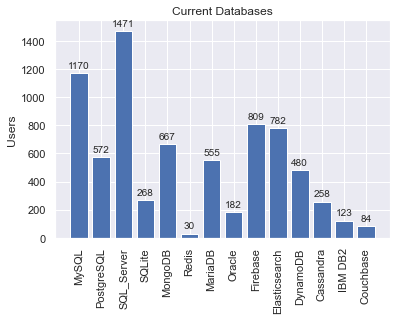

In [27]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Databases')

# ax.bar(x - width/2, Current_DBs, width, label='Current_DBs')

pps = plt.bar(labels,Current_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [28]:
Des_MySQL = count_db(df_toy, "DesiredDB0","MySQL")
Des_PostgreSQL = count_db(df_toy, "DesiredDB0","PostgreSQL")
Des_Microsoft_SQL_Server = count_db(df_toy, "DesiredDB0","Microsoft SQL Server")
Des_SQLite = count_db(df_toy, "DesiredDB0","SQLite")
Des_MongoDB = count_db(df_toy, "DesiredDB0","MongoDB")
Des_Redis = count_db(df_toy, "DesiredDB0","Redis")
Des_MariaDB = count_db(df_toy, "DesiredDB0","MariaDB")
Des_Oracle = count_db(df_toy, "DesiredDB0","Oracle")
Des_Firebase = count_db(df_toy, "DesiredDB0","Firebase")
Des_Elasticsearch = count_db(df_toy, "DesiredDB0","Elasticsearch")
Des_DynamoDB = count_db(df_toy, "DesiredDB0","DynamoDB")
Des_Cassandra = count_db(df_toy, "DesiredDB0","Cassandra")
Des_IBM_DB2 = count_db(df_toy, "DesiredDB0","IBM DB2")
Des_Couchbase= count_db(df_toy, "DesiredDB0","Couchbase")

Desired_DBs = [
Des_MySQL,
Des_PostgreSQL,
Des_Microsoft_SQL_Server,
Des_SQLite,
Des_MongoDB,
Des_Redis,
Des_MariaDB,
Des_Oracle,
Des_Firebase,
Des_Elasticsearch,
Des_DynamoDB,
Des_Cassandra,
Des_IBM_DB2,
Des_Couchbase
]

sum = 0
for i in Desired_DBs:
    sum += i
print(sum)

7451


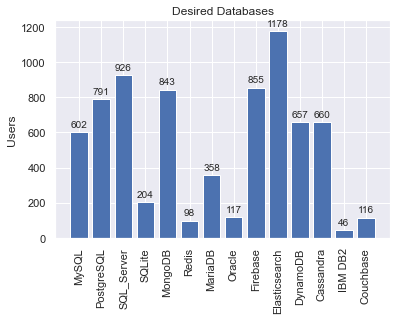

In [29]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Databases')

pps = plt.bar(labels,Desired_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [30]:
def count_platforms(df_toy, column_string,platform_name):
    '''Count the number of desired platforms'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == platform_name:
            counter += 1
    return counter


In [31]:
# Linux
# Windows
# Docker
# AWS
# Android
# MacOS
# Rasberry Pi
# Microsoft Azure
# WordPress
# Google Cloud Platform
# iOS
# Kubernetes
# Heroku
# Arduino
# Slack Apps and Integrations
# IBM Cloud or Watson

Linux = count_platforms(df_toy, "DesiredPlatform0","Linux")
Windows = count_platforms(df_toy, "DesiredPlatform0","Windows")
Docker = count_platforms(df_toy, "DesiredPlatform0","Docker")
AWS = count_platforms(df_toy, "DesiredPlatform0","AWS")
Android = count_platforms(df_toy, "DesiredPlatform0","Android")
MacOS = count_platforms(df_toy, "DesiredPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "DesiredPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "DesiredPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "DesiredPlatform0","WordPress")
Google = count_platforms(df_toy, "DesiredPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "DesiredPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "DesiredPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "DesiredPlatform0","Heroku")
Arduino= count_platforms(df_toy, "DesiredPlatform0","Arduino")
Slack = count_platforms(df_toy, "DesiredPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "DesiredPlatform0","IBM Cloud or Watson")

Desired_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Desired_Platforms:
    sum += i
print(sum)


7451


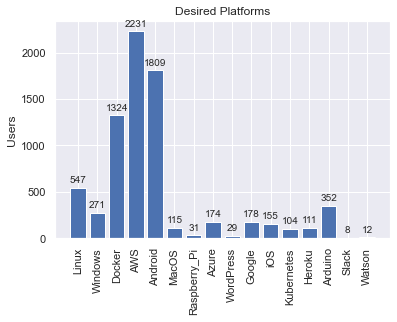

In [32]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Platforms')

pps = plt.bar(labels,Desired_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [33]:
#PlatformWorkedWith0

Linux = count_platforms(df_toy, "CurrentPlatform0","Linux")
Windows = count_platforms(df_toy, "CurrentPlatform0","Windows")
Docker = count_platforms(df_toy, "CurrentPlatform0","Docker")
AWS = count_platforms(df_toy, "CurrentPlatform0","AWS")
Android = count_platforms(df_toy, "CurrentPlatform0","Android")
MacOS = count_platforms(df_toy, "CurrentPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "CurrentPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "CurrentPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "CurrentPlatform0","WordPress")
Google = count_platforms(df_toy, "CurrentPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "CurrentPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "CurrentPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "CurrentPlatform0","Heroku")
Arduino= count_platforms(df_toy, "CurrentPlatform0","Arduino")
Slack = count_platforms(df_toy, "CurrentPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "CurrentPlatform0","IBM Cloud or Watson")

Current_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Current_Platforms:
    sum += i
print(sum)

7451


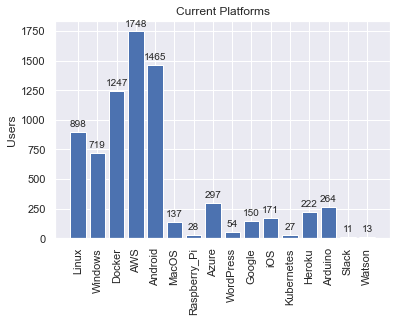

In [34]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Platforms')

pps = plt.bar(labels,Current_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [35]:
#One-hot encoding
X = pd.get_dummies(df_toy, columns= ['DevType','CurrentDB0', 'DesiredDB0','CurrentPlatform0'])

In [36]:
def desired_platform_y(df_toy, column_string, label):
    
    label_name = []
    for i in df_toy[column_string]:
        if i == label:
            label_name.append(1)
        else:
            label_name.append(0) 
    return label_name

Azure_y = (desired_platform_y(df_toy, 'DesiredPlatform0', "Microsoft Azure"))
AWS_y = (desired_platform_y(df_toy, 'DesiredPlatform0', "AWS"))
Google_y = (desired_platform_y(df_toy, 'DesiredPlatform0', "Google Cloud Platform"))
Android_y = (desired_platform_y(df_toy, 'DesiredPlatform0', "Android"))
Docker_y = (desired_platform_y(df_toy, 'DesiredPlatform0', "Docker"))
Linux_y = (desired_platform_y(df_toy, 'DesiredPlatform0', "Linux"))
np.count_nonzero(Google_y)

178

In [37]:
X = X.drop(['Country','DesiredPlatform0'], axis = 1)

In [46]:
y_labels = pd.DataFrame(
    {'Azure_y': Azure_y,
     'AWS_y': AWS_y,
     'Google_y': Google_y,
     'Android_y': Android_y,
     'Docker_y': Docker_y,
     'Linux_y': Linux_y,
    })

In [67]:
#Choose a Desired platform to test

# for i, j in y_labels.iteritems():
# #     print(j)
        
#         X_train, X_test, y_train, y_test = train_test_split(X,i, test_size = .2)
#         clf = DecisionTreeClassifier()
#         cv = StratifiedKFold(n_splits = 5) 
#         scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
#         print(scores.mean())
        

y_label = Azure_y
        
X_train, X_test, y_train, y_test = train_test_split(X,y_label, test_size = .2)
clf = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits = 5) 
scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
print(scores.mean())


0.975


In [68]:
my_fav_clf = DecisionTreeClassifier(min_samples_leaf=25, max_depth=10,min_samples_split=25)
my_fav_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=25)

In [69]:
# Extract Column Names as List in Pandas Dataframe

predictor_names = X.columns.tolist()

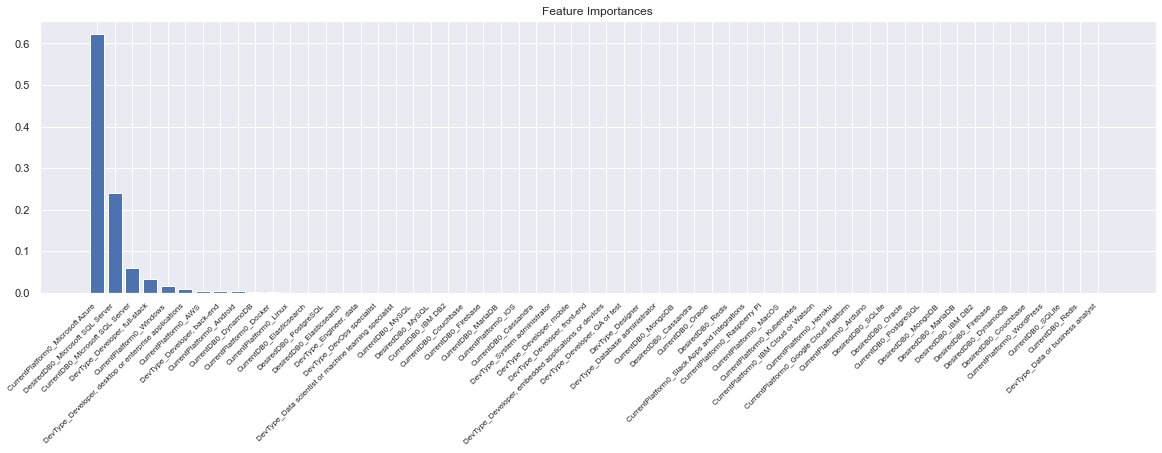

In [70]:
# Determine most important features

importances = my_fav_clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');